<a href="https://colab.research.google.com/github/cdiegor/Metaheuristicas/blob/main/PEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema de Escalonamento de Veículos

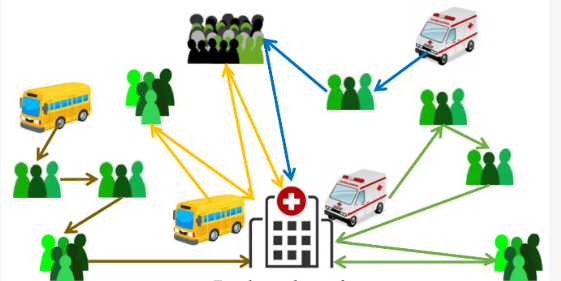

## Introdução

O problema de escalonamento de veículos (VSP) está relacionado com o agendamento de um número de veículos que devem visitar um número de locais para pegar ou entregar mercadorias ou realizar algum serviço. Os termos "veículo" e
"local" foram usados para fornecer uma cenário, mas muitas aplicações do modelo PEV têm nada a ver com veículos reais visitando locais. O problema é algumas vezes referido na literatura como o problema do despacho do caminhão, roteirização do transporte, roteamento de veículos, ou o problema de entrega.

Fonte: C.D.T. WATSON-GANDY, **THE VEHICLE SCHEDULING PROBLEM: A SURVEY**. Operations Research Society of New Zealand, 1981.

### Definição do problema

Vamos considerar que temos como entrada um grafo $G = (V, A)$ completo no qual um nó específico é chamado de depósito. Os demais nós do grafo são os clientes. Para qualquer arco $(u,v) \in A$, vamos considerar conhecida uma métrica $t(u,v)$ o tempo de deslocamento entre os nós $u$ e $v$.

Além disso temos um conjunto de tarefas $J$, cada uma delas com uma data de início $d_j$ e uma duração de execução $p_j$. Estas tarefas possuem também uma sequência de nós $S_j$ que devem ser visitados para cumprir a tarefa.

Com uma frota limitada em $R$ veículos, queremos determinar qual é o conjunto de rotas a serem repartidas entre eles de forma a atender todas as tarefas com um atraso total mínimo.

Por simplicidade, vamos reproduzir o que foi realizado no problema do caixeiro viajante e considerar que cada vértice do grafo é um ponto num espaço euclidiano $\mathbb{R}^2$ e que a métrica de tempo é a própria distância euclidiana.

In [1]:
import matplotlib.pyplot as plt
import math
import random
import time
import itertools
import urllib
import csv

In [2]:
def distancia(x,y):
  return math.dist(x,y)/1000

In [3]:
class Tarefa:
  def __init__(self):
    self.index: int = 0
    self.data: float = 0
    self.duracao: float = 0
    self.seq:list[tuple[int, int]] = []

  def duracao_total(self):
    return self.duracao + tamanho_rota(self.seq)

  def __str__(self):
    return f"Data = {self.data}\tDuracao = {self.duracao_total()}\t Rota = {self.seq}"
  def __repr__(self):
    return f"{self.index}"

class PEV:
  def __init__(self):
    self.clientes:list[tuple[int, int]] = []
    self.tarefas:list[Tarefa] = []
    self.veiculos:int = 0
    self.rotas: list[list[Tarefa]] = []
    self.atraso: float

  def atraso_rota(self, r: int):
    atraso = 0.
    t = 0.
    local = self.clientes[0]
    for i in range(len(self.rotas[r])):
      t += distancia(local, self.rotas[r][i].seq[0])
      atraso += max(t - self.rotas[r][i].data, 0)
      t += self.rotas[r][i].duracao_total()
      local = self.rotas[r][i].seq[-1]
    return atraso

  def atraso_total(self):
    return sum(self.atraso_rota(r) for r in range(self.veiculos))

  def __repr__(self):
    return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.veiculos}\tCusto = {self.atraso_total()}"
  def __str__(self):
    return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.veiculos}\tCusto = {self.atraso_total()}"

In [4]:
def tamanho_rota(rota):
  "A distância total percorrida entre dois pares consecutivos em uma rota"
  return sum(distancia(rota[i-1], rota[i]) for i in range(len(rota)))

### Construindo instâncias fictícias

In [5]:
import copy
import math
import random

def gerar_pev(n: int, r: int, t: int,
              largura: int = 1000,
              altura: int = 1000,
              rseed: int = 233) -> PEV:
  """
  Cria uma instância do PEV com n clientes, r veículos e t tarefas.

  Os clientes são colocados ao redor do depósito e, na construção das tarefas,
  as sequências de clientes de uma mesma tarefa são formadas de modo que
  clientes consecutivos fiquem relativamente próximos no plano.
  """
  pev = PEV()
  random.seed(rseed)
  pev.veiculos = r

  # Gera n clientes em torno do depósito (0) em quatro quadrantes
  pev.clientes = [
      (
          largura // 2 + (2 * random.randrange(2) - 1) * (100 + random.randrange(largura // 2 - 100)),
          altura  // 2 + (2 * random.randrange(2) - 1) * (100 + random.randrange(altura  // 2 - 100)),
      )
      for _ in range(n + 1)
  ]
  # Depósito no centro
  pev.clientes[0] = (largura // 2, altura // 2)

  # Número de "janelas" de tempo (evita divisão por zero)
  intervalos = max(1, t // max(1, r))

  # Cria t tarefas com data e duração aleatórias
  pev.tarefas = []
  for j in range(t):
    tar = Tarefa()
    tar.index = j
    tar.data = random.randrange(intervalos) * 0.5 + random.random()
    tar.duracao = random.random()
    tar.seq = []  # sequência de clientes será preenchida abaixo
    pev.tarefas.append(tar)

  # Vamos trabalhar com índices de clientes (1..n)
  faltantes = list(range(1, n + 1))

  if t >= len(faltantes):
    # Caso extremo: mais tarefas do que clientes.
    # Cada cliente vai para uma tarefa diferente; algumas tarefas ficam vazias.
    random.shuffle(faltantes)
    for j, c_idx in enumerate(faltantes):
      pev.tarefas[j].seq.append(pev.clientes[c_idx])
  else:
    # 1ª fase: escolhe um cliente "semente" para cada tarefa
    sementes = random.sample(faltantes, t)
    ult_cliente = {}  # guarda o último cliente de cada tarefa (por índice)
    for j, c_idx in enumerate(sementes):
      pev.tarefas[j].seq.append(pev.clientes[c_idx])
      ult_cliente[j] = c_idx
      faltantes.remove(c_idx)

    # 2ª fase: enquanto houver clientes sem tarefa, agrupa por proximidade
    while faltantes:
      if len(faltantes) >= t:
        # Ainda dá para adicionar 1 cliente em cada tarefa
        for j in range(t):
          base_idx = ult_cliente[j]
          base_coord = pev.clientes[base_idx]
          melhor_idx = None
          melhor_dist = float("inf")
          for c_idx in faltantes:
            d = distancia(base_coord, pev.clientes[c_idx])
            if d < melhor_dist:
              melhor_dist = d
              melhor_idx = c_idx
          pev.tarefas[j].seq.append(pev.clientes[melhor_idx])
          ult_cliente[j] = melhor_idx
          faltantes.remove(melhor_idx)
      else:
        # Menos clientes do que tarefas: cada cliente vai para a tarefa cujo
        # último cliente está mais próximo
        for c_idx in list(faltantes):
          c_coord = pev.clientes[c_idx]
          melhor_tarefa = None
          melhor_dist = float("inf")
          for j in range(t):
            if j in ult_cliente:
              base_coord = pev.clientes[ult_cliente[j]]
            else:
              base_coord = pev.clientes[0]  # se alguma tarefa estiver vazia
            d = distancia(base_coord, c_coord)
            if d < melhor_dist:
              melhor_dist = d
              melhor_tarefa = j
          pev.tarefas[melhor_tarefa].seq.append(c_coord)
          ult_cliente[melhor_tarefa] = c_idx
          faltantes.remove(c_idx)

  # Inicializa as rotas vazias (uma lista por veículo)
  pev.rotas = [[] for _ in range(r)]

  return pev


In [6]:
gerar_pev(30, 4, 40)

Clientes = 30	Veiculos = 4	Custo = 0.0

### Desenhando a solução

In [7]:
def plot_rota(deposito, rota, cor):
  x = []
  y = []
  text = []
  style = []

  x.append(deposito[0])
  y.append(deposito[1])
  text.append('')
  style.append('dashed')
  for i in range(len(rota)):
    for j in range(len(rota[i].seq)):
      x.append(rota[i].seq[j][0])
      y.append(rota[i].seq[j][1])
      text.append(rota[i].index)
      if (j < len(rota[i].seq)-1):
        style.append('solid')
      else:
        style.append('dashed')

  for i in range(len(x)):
    plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=cor, linewidth=2, linestyle=style[i-1])

  plt.scatter(x, y, color=cor, linewidth=10)

  for i in range(len(x)):
    plt.annotate(text[i], (x[i]-10, y[i]-10 ))


In [8]:
import seaborn as sns;
def plot_pev(pev):

  print(pev)

  palette = itertools.cycle(sns.color_palette("colorblind", pev.veiculos))
  for rota in pev.rotas:
    plot_rota(pev.clientes[0], rota, next(palette))

  plt.plot(pev.clientes[0][0], pev.clientes[0][1],
           marker="D", markersize=10, markeredgecolor="black", markerfacecolor="grey")
  plt.axis("scaled")

  plt.show()


Data = 1.9788547276653543	Duracao = 0.7641732586824607	 Rota = [(111, 631), (88, 759)]
Data = 0.3296922178940317	Duracao = 1.8214445256596452	 Rota = [(143, 977), (195, 302)]
Data = 1.7463106164255238	Duracao = 1.4026947029118408	 Rota = [(967, 44), (810, 195)]
Data = 0.6338328843874979	Duracao = 1.2904949881658818	 Rota = [(45, 361), (291, 219)]
Data = 1.5070638031291734	Duracao = 0.7228317403903475	 Rota = [(779, 909), (783, 665)]
Data = 1.094177735845785	Duracao = 1.2615547434333998	 Rota = [(295, 872), (358, 263)]
Data = 1.574161610203404	Duracao = 0.5674698754031273	 Rota = [(162, 41), (90, 17)]
Data = 1.2605410872820575	Duracao = 0.9248788600407063	 Rota = [(983, 667), (806, 363)]
Data = 0.28463224255523545	Duracao = 1.4143902024227348	 Rota = [(659, 764), (753, 89)]
Data = 1.785028490210276	Duracao = 2.685247051243918	 Rota = [(356, 848), (372, 1)]
Clientes = 20	Veiculos = 3	Custo = 21.028739814021222


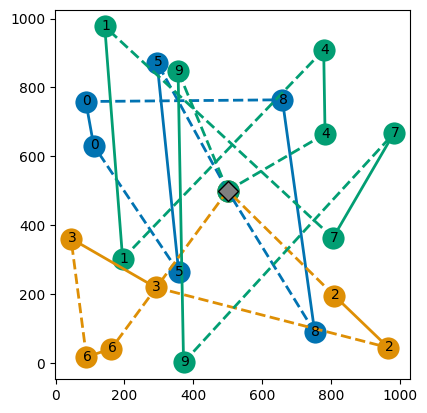

In [9]:
nc = 20
nv = 3
nt = 10

pev = gerar_pev(nc, nv, nt)

for x in pev.tarefas:
  print(x)

taf = copy.deepcopy(pev.tarefas)
random.shuffle(taf)
for i in range(nv):
  pev.rotas[i] = taf[i*nt//nv:(i+1)*nt//nv]

plot_pev(pev)



In [10]:
for rota in pev.rotas:
  print(rota)

[5, 0, 8]
[6, 3, 2]
[9, 7, 1, 4]


## Algoritmo Genético para o PEV

### População inicial

In [11]:
def populacao_inicial(pev: PEV, tamanho_populacao: int):
  Populacao:PEV = []
  for i in range(tamanho_populacao):
    x = copy.deepcopy(pev)
    random.shuffle(x.tarefas)
    for r in range(x.veiculos):
      x.rotas[r] = x.tarefas[r*len(x.tarefas)//x.veiculos:(r+1)*len(x.tarefas)//x.veiculos]
    Populacao.append(x)
  return Populacao

### Operadores de cruzamento



In [12]:
import copy

def encontrar(vetor, elemento):
  index:int = 0
  while (index < len(vetor)):
    if vetor[index].index == elemento.index:
      return index
    index = index + 1
  return -1


def cruzamento_aresta_alternada(mae1, mae2):
  filha = []
  restante = copy.deepcopy(mae1)
  n = len(mae1)

  # Selecionar um ponto inicial
  atual = mae1[random.randrange(n)]
  rindex = encontrar(restante, atual)
  iter = 0
  del restante[rindex]
  filha.append(atual)

  # Cruzamento de aresta alternata
  while len(restante) > 0:
    # Encontrar o indice da tarefa atual na mae
    if iter % 2 == 0: indice = encontrar(mae1, atual)
    else:             indice = encontrar(mae2, atual)

    # Encontrar o elemento seguinte
    naoEncontrado = True
    while naoEncontrado:
      indice = (indice + 1)%n
      naoEncontrado = False
      if iter % 2 == 0: rindex = encontrar(restante, mae1[indice])
      else:             rindex = encontrar(restante, mae2[indice])

      if rindex < 0:
        naoEncontrado = True
    if iter % 2 == 0: atual = mae1[indice]
    else:             atual = mae2[indice]

    del restante[rindex]
    filha.append(atual)
    iter = iter + 1

  return filha

### Operadores de mutação

In [13]:
def localizar(S: PEV, i: int, j: int):
  ri: int = -1 # Rota da tarefa i
  li: int = -1 # Local da tarefa i na rota
  rj: int = -1 # Rota da tarefa j
  lj: int = -1 # Local da tarefa j na rota

  for k, rota in enumerate(S.rotas):
    for l, tarefa in enumerate(rota):
      if tarefa.index == S.tarefas[i].index:
        ri = k
        li = l
      if tarefa.index == S.tarefas[j].index:
        rj = k
        lj = l
  return ri, li, rj, lj

def trocar(S:PEV, i:int, j: int):
  ri, li, rj, lj = localizar(S, i, j)
  S.rotas[ri][li] = S.tarefas[j]
  S.rotas[rj][lj] = S.tarefas[i]

def mover(S:PEV, i:int, j: int):
  ri, li, rj, lj = localizar(S, i, j)
  del S.rotas[rj][lj]
  if ri == rj and lj < li:
    S.rotas[ri].insert(li, S.tarefas[j])
  else:
    S.rotas[ri].insert(li+1, S.tarefas[j])

def reverter(S:PEV, i:int, j: int):
  ri, li, rj, lj = localizar(S, i, j)
  if ri == rj:
    if (li < lj):
      S.rotas[ri][li:lj] = reversed(S.rotas[ri][li:lj])
    else:
      S.rotas[rj][lj:li] = reversed(S.rotas[rj][lj:li])

### Algoritmo Genético

In [14]:
def avaliar_populacao(populacao: list[PEV], elite):
  for x in populacao : x.atraso = x.atraso_total()
  populacao.sort(key=lambda x : x.atraso)

In [15]:
def torneio(populacao: list[PEV], elite: float, vies: float, rodadas: int):
  v = random.uniform(0, 1)
  iter = 1
  while (iter <= rodadas):
    if (v < vies):
      candidato = random.randrange(round(len(populacao)*elite))
    else:
      candidato = random.randrange(len(populacao))
    if (iter == 1):
      melhor = candidato
    elif (populacao[candidato].atraso < populacao[melhor].atraso):
      melhor = candidato
    iter = iter + 1
  return melhor

def selecao(populacao: list[PEV], elite: float, vies: float, rodadas: int):
  x = torneio(populacao, elite, vies, rodadas)
  y = torneio(populacao, elite, vies, rodadas)
  return x, y

In [16]:
def checar_rotas(x: PEV):
  check = [0] * len(x.tarefas)
  for r in x.rotas:
    for t in r:
      check[t.index] = 1
  return sum(check) == len(x.tarefas)

In [17]:
def mutacao(x: PEV):
  v = random.uniform(0, 1)
  i = random.randrange(len(x.tarefas))
  j = random.randrange(len(x.tarefas) - 1)
  if j >= i:
    j += 1
  if (v < 1/3):
    trocar(x, i, j)
  elif (v < 2/3):
    mover(x, i, j)
  else:
    reverter(x, i, j)

In [18]:
def cruzamento(x: PEV, y: PEV):

  px = []
  for r in x.rotas: px.extend(r)
  py = []
  for r in y.rotas: py.extend(r)


  pa = cruzamento_aresta_alternada(px, py)
  pb = cruzamento_aresta_alternada(py, px)

  a = copy.deepcopy(x)
  a.rotas = []
  inicio = 0
  for r in x.rotas:
    fim = inicio + len(r)
    a.rotas.append(pa[inicio:fim])
    inicio = fim

  b = copy.deepcopy(y)
  b.rotas = []
  inicio = 0
  for r in y.rotas:
    fim = inicio + len(r)
    b.rotas.append(pb[inicio:fim])
    inicio = fim

  if checar_rotas(a) == False or checar_rotas(b) == False:
    print("Erro no cruzamento")

  return a, b

In [19]:
def checar_pop(pop):
  for j in range(len(pop)):
    x = pop[j]
    if (len(x.rotas) < x.veiculos):
      print("Menos rotas que veiculos no individuo ", j)
    for r in range(len(x.rotas)):
      if (len(x.rotas[r]) == 0):
        print("Rota ", r, " vazia no individuo", j)

def genetico(pev: PEV, tamanho_populacao: int, elite: float,
             vies: float, taxa_mutacao: float, rodadas: int, max_geracao:int,
             verbose=False):
  proxima = populacao_inicial(pev, tamanho_populacao)
  avaliar_populacao(proxima, elite)
  geracao = 0
  tamanho_elite = round(tamanho_populacao*elite)
  tamanho_mutacao = round(tamanho_populacao*taxa_mutacao)

  while (geracao < max_geracao):
    atual = copy.deepcopy(proxima)

    #Próxima geração mantém a elite atual
    proxima[:tamanho_elite] = copy.deepcopy(atual[:tamanho_elite])

    # Elementos mutantes da próxima população
    for j in range(tamanho_elite,tamanho_elite+tamanho_mutacao):
      mutant_index = torneio(atual, elite, vies, rodadas)
      proxima[j] = copy.deepcopy(atual[mutant_index])
      #print("  mutacao")
      mutacao(proxima[j])

    # Elementos cruzados da próxima população
    j = tamanho_elite+tamanho_mutacao
    while (j < tamanho_populacao):
      x, y = selecao(atual, elite, vies, rodadas)
      z, w = cruzamento(atual[x], atual[y])
      proxima[j] = z
      j = j + 1
      if (j < tamanho_populacao):
        proxima[j] = w
        j = j + 1
    avaliar_populacao(proxima, elite)
    geracao = geracao + 1
    if verbose: print("(", geracao, "): Melhor solucao = ", proxima[0].atraso)
  return proxima[0]

### Averiguando parâmetros

( 1 ): Melhor solucao =  72.87830174175868
( 2 ): Melhor solucao =  70.56137063726433
( 3 ): Melhor solucao =  70.56137063726433
( 4 ): Melhor solucao =  67.92308726327443
( 5 ): Melhor solucao =  67.46540407819563
( 6 ): Melhor solucao =  66.64171461717928
( 7 ): Melhor solucao =  64.91759472040088
( 8 ): Melhor solucao =  64.91759472040088
( 9 ): Melhor solucao =  62.76271617825807
( 10 ): Melhor solucao =  55.45297312402025
( 11 ): Melhor solucao =  55.45297312402025
( 12 ): Melhor solucao =  55.08909489340222
( 13 ): Melhor solucao =  52.841789060720075
( 14 ): Melhor solucao =  52.841789060720075
( 15 ): Melhor solucao =  50.18719483757472
( 16 ): Melhor solucao =  49.74433880304689
( 17 ): Melhor solucao =  48.29609367470936
( 18 ): Melhor solucao =  48.29609367470936
( 19 ): Melhor solucao =  48.29609367470936
( 20 ): Melhor solucao =  46.47532304738328
( 21 ): Melhor solucao =  46.47532304738328
( 22 ): Melhor solucao =  46.47532304738328
( 23 ): Melhor solucao =  45.7718506190

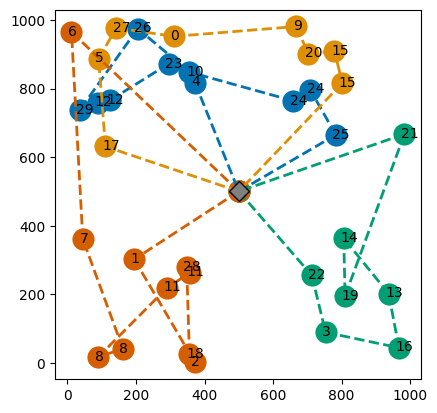

In [20]:
pontos = 35
veiculos = 4
tarefas = 30

exemplo = gerar_pev(pontos, veiculos, tarefas)

solucao = genetico(exemplo,
                   tamanho_populacao=80, elite=0.2, vies=0.5,
                   taxa_mutacao=0.5, rodadas=3, max_geracao=400,
                   verbose=True)

plot_pev(solucao)


## Ajuste de parâmetros do algoritmo genético

Nesta seção vamos experimentar diferentes combinações de parâmetros
(tamanho da população, percentual de elite, taxa de mutação e viés do
torneio) para observar o impacto na qualidade das soluções.

A ideia não é fazer um tuning exaustivo, mas mostrar como comparar
configurações de forma sistemática: várias rodadas por configuração,
registro das melhores soluções e análise dos resultados em tabela.


In [21]:
import pandas as pd

# Parâmetros base da instância a ser usada no tuning
nc = 35
nv = 3
nt = 30
instancia_base = gerar_pev(nc, nv, nt, rseed=123)

def rodar_config(pev_base: PEV,
                 tam_pop: int,
                 elite: float,
                 vies: float,
                 taxa_mut: float,
                 rodadas: int,
                 max_geracao: int,
                 repeticoes: int = 5,
                 rseed: int = 0) -> dict:
  """
  Executa 'repeticoes' rodadas do AG com a mesma configuração
  e retorna métricas agregadas de qualidade.
  """
  random.seed(rseed)
  resultados = []
  for rep in range(repeticoes):
    pev = copy.deepcopy(pev_base)
    sol = genetico(
        pev,
        tamanho_populacao=tam_pop,
        elite=elite,
        vies=vies,
        taxa_mutacao=taxa_mut,
        rodadas=rodadas,
        max_geracao=max_geracao
    )
    resultados.append(sol.atraso_total())
    print(sol.atraso_total())

  return {
      "tam_pop": tam_pop,
      "elite": elite,
      "vies": vies,
      "taxa_mutacao": taxa_mut,
      "rodadas": rodadas,
      "max_geracao": max_geracao,
      "media_atraso": sum(resultados) / len(resultados),
      "melhor_atraso": min(resultados),
      "pior_atraso": max(resultados),
  }

# Grade de parâmetros a testar
configs = []
for tam_pop in [30, 50, 80]:
  for elite in [0.1, 0.2, 0.3]:
    for taxa_mut in [0.1, 0.3, 0.5]:
      configs.append((tam_pop, elite, 0.5, taxa_mut, 3, 100))

resultados = []
for (tam_pop, elite, vies, taxa_mut, rodadas, max_geracao) in configs:
  res = rodar_config(
      instancia_base,
      tam_pop=tam_pop,
      elite=elite,
      vies=vies,
      taxa_mut=taxa_mut,
      rodadas=rodadas,
      max_geracao=max_geracao,
      repeticoes=5
  )
  resultados.append(res)
  print(
      f"pop={tam_pop:3d}, elite={elite:.1f}, mut={taxa_mut:.1f} -> "
      f"média={res['media_atraso']:.3f}, "
      f"melhor={res['melhor_atraso']:.3f}, "
      f"pior={res['pior_atraso']:.3f}"
  )

df_tuning = pd.DataFrame(resultados).sort_values("media_atraso")
df_tuning.head()


39.86478418625955
34.57368105150051
33.08474626427182
39.98681052491102
46.42167923470437
pop= 30, elite=0.1, mut=0.1 -> média=38.786, melhor=33.085, pior=46.422
32.36650931013255
30.621288969652447
30.42284857240997
34.69590935876832
31.288685997443938
pop= 30, elite=0.1, mut=0.3 -> média=31.879, melhor=30.423, pior=34.696
31.68715081874154
29.88893799513067
26.571870332559435
32.5443442062161
31.15953708039208
pop= 30, elite=0.1, mut=0.5 -> média=30.370, melhor=26.572, pior=32.544
38.307460166632794
41.251843824709226
44.200653769669934
40.665534106281115
36.65215573577461
pop= 30, elite=0.2, mut=0.1 -> média=40.216, melhor=36.652, pior=44.201
37.99997859855965
31.322561890149032
31.2840051375358
34.04504344678647
32.254058268497985
pop= 30, elite=0.2, mut=0.3 -> média=33.381, melhor=31.284, pior=38.000
32.43950296094623
28.475847895044645
27.85716406878678
34.42449446430303
30.019045154197098
pop= 30, elite=0.2, mut=0.5 -> média=30.643, melhor=27.857, pior=34.424
41.39462478218893
3

,tam_pop,elite,vies,taxa_mutacao,rodadas,max_geracao,media_atraso,melhor_atraso,pior_atraso
26,80,0.3,0.5,0.5,3,100,26.592972,24.726644,28.617921
20,80,0.1,0.5,0.5,3,100,27.619511,24.656669,29.443448
23,80,0.2,0.5,0.5,3,100,27.667429,23.702514,29.715413
19,80,0.1,0.5,0.3,3,100,27.703081,23.643789,31.837684
11,50,0.1,0.5,0.5,3,100,27.960137,25.152520,29.461826


## Exercícios


1.   Adapte o algoritmo genético para produzir um gráfico mostrando a evolução do valor da melhor solução e da média das soluções na população ao longo das iterações.

2. Exploração sistemática de parâmetros

  a) Monte uma grade de parâmetros envolvendo, pelo menos:

    tamanhos de população: 30, 50, 80
    percentuais de elite: 0.1, 0.2, 0.3
    taxas de mutação: 0.1, 0.3, 0.5

Para cada combinação, rode o AG 5 vezes e registre: média, melhor e pior atraso total.

  b) Organize os resultados em um DataFrame (como df_tuning) e apresente: uma tabela com as 5 melhores configurações (ordenadas pela média de atraso); um gráfico simples relacionando: média do atraso x tamanho da população (fixando elite e mutação nas melhores faixas encontradas); média do atraso x taxa de mutação.

  c) Com base nos resultados, responda: qual a melhor versão em média? Há evidências de correlação entre os parâmetros testados e a qualidade de resultado obtida?

  d) Compare duas versões de parâmetros, uma boa e outra ruim. Compare as distribuições de atraso total em cada uma das cinco execuções. Qual a diferença entre qualidade média e estabilidade?

  e) Você consegue eleger a melhor versão? Argumente.

## Exercício Mestrado

3.   Elabore um novo operador de cruzamento para o algoritmo genético. Existe um ganho de qualidade do algoritmo com este outro operador? Argumente utilizando múltiplas execuções do algoritmo para diferentes entradas.

